<DIV ALIGN=CENTER>

# Introduction to Practical Concepts
## Professor Robert J. Brunner
  
</DIV>  
-----
-----


## Introduction

In this IPython Notebook, we explore a number of practical concepts that
can be very important in real-world machine learning applications.
These concepts include

2. Feature Scaling
1. Feature Selection
3. Pipelining
6. Cross Validation
5. Grid Search
4. Validation/Learning Curves

In the rest of this Notebook, we demonstrate these concepts by using the
Iris and Handwritten Digit data sets. First, we set up our Notebook's
environment.

-----

In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


-----

## Feature Scaling

A Machine learning application is often focused on learning a model from
a data set. If a data set has features that are vastly different, either
in terms of their range (e.g., minimum and maximum values), their
typical value (e.g., mean or median value), or their overall
distribution (e.g., Gaussian, Poisson, or Exponential), the generated
model can be biased. In order to mitigate these effects, we typically
will want to scale the input features so that they are more similar. 

The scikit learn library provides a number of different scaling
techniques, that can scale the features as needed. For example, the
`StandardScaler` object will scale features to each have zero mean and
unit standard deviation, while the `MinMaxScaler` object will scale
features to lie with the range zero to one, inclusively. The type of
scaling employed will, in some cases, depend on the type of machine
learning application. We demonstrate using scaling in the following code
cells, where we first obtain the Iris data and plot the normal data and
then the scaled data, by using the `StandardScaler`.

-----

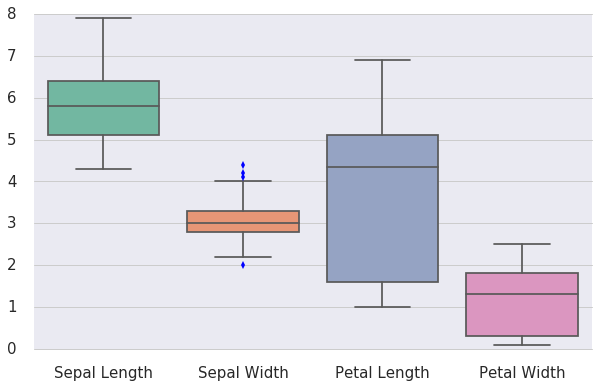

In [2]:
iris = sns.load_dataset('iris')
# Make a box plot to show distributions
fig, axs = plt.subplots(figsize=(10,6))
sns.set(style="white", font_scale=1.5)

iris.columns = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width', 'Species']
sns.boxplot(data=iris, orient="v", palette="Set2", ax=axs)
sns.despine(offset=10)

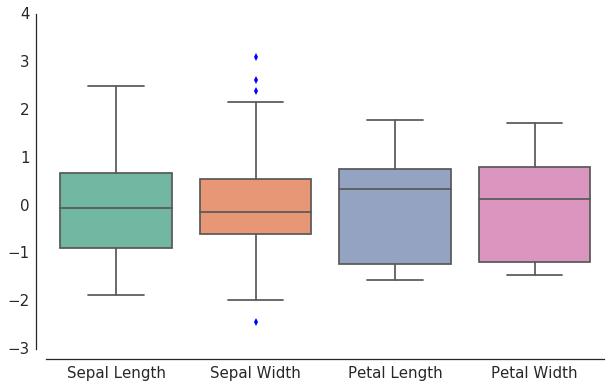

In [3]:
from sklearn import preprocessing

# We can scale in different manners
s_iris = pd.DataFrame(preprocessing.scale(iris.values[:,0:4]))
#s_iris = pd.DataFrame(preprocessing.normalize(iris.values[:,0:4]))

# Make a box plot to show distributions
fig, axs = plt.subplots(figsize=(10,6))
sns.set(style="white", font_scale=1.5)

s_iris.columns = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']
sns.boxplot(data=s_iris, orient="v", palette="Set2", ax=axs)
sns.despine(offset=10)

-----

As the two previous figures demonstrate, after scaling, the Iris
features are distributed about zero, with unit standard deviation. We
can now compare the classification of these data before and after
scaling, in this specific case we use the SVM algorithm. Note that when
running the next cell, we are obtaining random samples of data from
`train_test_split` and thus obtain different results each time. Since
these data are both small and an easy data set to classify, scaling
produces little or no improvement (in some cases it can make the results
slightly worse). This is likely due to the fact that the features in the
original data are already very similar, spanning nearly the same range
with similar distributions. 


-----

In [4]:
from sklearn import svm
from sklearn import cross_validation as cv
from sklearn.metrics import classification_report

# Get our original data
x = iris.values[:,0:4]
y = np.array([i//50 for i in range(iris.shape[0])])

# Get training and tesign data
(x_train, x_test, y_train, y_test) = cv.train_test_split(x, y, test_size=.4)

# Next lets try Linear SVM
svc = svm.SVC(kernel='linear', C=0.1)
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)

print("SVM prediction accuracy = {0:5.1f}%".format(100.0 * svc.score(x_test, y_test)))
print(classification_report(y_test, y_pred, \
                            target_names = ['Setosa', 'Versicolor', 'Virginica']))

# Compute scaling from training data only
ps = preprocessing.StandardScaler().fit(x_train)

# Now transformt the input training and testing data
xs_train = ps.transform(x_train)
xs_test = ps.transform(x_test)

# Fit and Predict
svc.fit(xs_train, y_train)
y_pred = svc.predict(xs_test)

print("SVM prediction accuracy = {0:5.1f}%".format(100.0 * svc.score(xs_test, y_test)))
print(classification_report(y_test, y_pred, \
                            target_names = ['Setosa', 'Versicolor', 'Virginica']))

SVM prediction accuracy =  96.7%
             precision    recall  f1-score   support

     Setosa       1.00      1.00      1.00        22
 Versicolor       0.95      0.95      0.95        19
  Virginica       0.95      0.95      0.95        19

avg / total       0.97      0.97      0.97        60

SVM prediction accuracy =  96.7%
             precision    recall  f1-score   support

     Setosa       1.00      1.00      1.00        22
 Versicolor       0.95      0.95      0.95        19
  Virginica       0.95      0.95      0.95        19

avg / total       0.97      0.97      0.97        60



-----

### Student Activity:

Now that you have run the previous cells, try making changes to the
Notebook:

1. Try using a different normalization technique, such as
`MinMaxScaler`. How do the results change?
2. Try scaling the _fake_ Iris data from the [Introduction to Anomaly
Detection][iad] Notebook. Does this help or hurt anomaly detection?

-----

## Feature Selection

Previously, when exploring [dimension reduction][idr], we saw that a
reduced set of new dimensions (e.g., PCA components) could capture most
of the variance in the data. Thus, rather than a large number of
features, we could use a smaller set of features in a machine learning
application. This had several important benefits, since fewer features
means less data to be analyzed, which means less memory is required for
the data, less data must be transferred, and algorithms will often run
faster. While this may not be important for all data sets, for example,
the Iris data, large analyses of multi-dimensional data sets can often
see dramatic improvement, for example, the Handwritten Digit data.

Dimensional reduction, however, can often be an expensive process. PCA,
as one example, typically involves a matrix inversion by using [Singular
Value Decomposition (SVD)][wsvd], which can be memory can compute
intensive. As a result, a first step in many machine learning
applications is the identification of the features in the data that are
most important, a process which is known as [_Feature Selection_][wfs].
The scikit learn provides a number of feature selection algorithms. The
two we will explore in this Notebook include [Recursive Feature
Elimination (RFE)][rfe] and [Random Forest Classifier (RFC)][rfc]. 

The RFE method works by recursively removing attributes and building a
model from the remaining attributes. The model accuracy is used to
identify the attributes (and combination of attributes) tha most
contribute to predicting the target (or held-out) attribute. RFC, on the
other hand, as an ensemble method, builds models by randomly selecting
features when building each tree. In this process, RFC computes the
overall importance of each feature in building the final model. By
extracting the feature importances from the final model, we obtain a
ranked ordering of the features used to build the model.

In the next few cells, we employ both RFE and RFC to determine the most
important features for both the Iris and Handwritten Digit data. Notice
how in the following, when using RFE we indicate the number of
attributes to select when building the model, while RFC simply displays
the importance of each feature.

-----

[iad]: intro2ad.ipynb
[wfs]: https://en.wikipedia.org/wiki/Feature_selection
[wsvd]: https://en.wikipedia.org/wiki/Singular_value_decomposition
[rfe]: http://scikit-learn.org/stable/modules/feature_selection.html#tree-based-feature-selection
[rfc]: http://scikit-learn.org/stable/modules/feature_selection.html#tree-based-feature-selection

In [5]:
from sklearn.feature_selection import RFE

# Number of attributes to keep
num_attributes = 3

# Create RFE model with target number of attributes
rfe = RFE(svc, num_attributes)
rfe = rfe.fit(x, y)
     
for idx, label in enumerate(s_iris.columns):
    if rfe.support_[idx]:
        print('Kept   : {0}'.format(label))
    else:
        print('Dropped: {0}'.format(label))

Dropped: Sepal Length
Kept   : Sepal Width
Kept   : Petal Length
Kept   : Petal Width


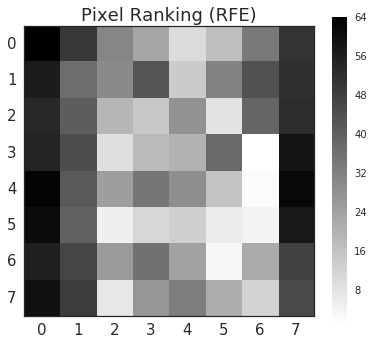

In [6]:
# We have helper code to assist in the loading and plotting of these data
from helper_code import digits as hd

# We extract features (x), labels (y), and the images for plotting.
x, y, images = hd.get_data()

from sklearn.feature_selection import RFE

# Create the RFE estimator
svc = svm.SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=1, step=1)

# Compute the pixel rankings
rfe.fit(x, y)
ranking = rfe.ranking_.reshape(images[0].shape)

# Plot the result
fig, axs = plt.subplots(figsize=(6.5, 5.5))
sns.set(style='dark', font_scale=1.0)
plt.gray()
plt.imshow(ranking, interpolation='nearest', cmap=plt.cm.gray_r)
plt.colorbar()
sns.set(style='dark', font_scale=1.5)
plt.title("Pixel Ranking (RFE)")
plt.show()

In [7]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

# Build model
rfc = RandomForestClassifier()
rfc.fit(xs_train, y_train)

# Display attributes in ranked order
print('{0:14s}: Importance'.format('Label'))
print(26*'-')
for val, label in zip(rfc.feature_importances_, s_iris.columns):
    print('{0:14s}: {1:04.2f}%'.format(label, 100.0 * val))

Label         : Importance
--------------------------
Sepal Length  : 6.40%
Sepal Width   : 5.48%
Petal Length  : 38.89%
Petal Width   : 49.22%


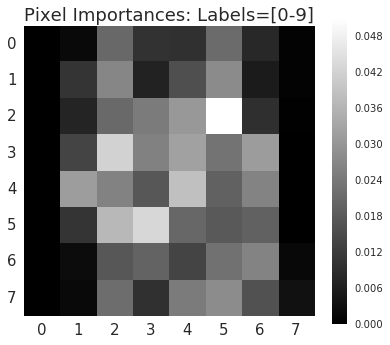

In [8]:
# We can restrict the classes (digit labels)
# By default, we keep themn all 0-9
minc = 0 ; maxc = 10
mask = (y >= minc) & (y < maxc)  # Limit classes
x = x[mask]
y = y[mask]

# Build Randomf Forest
rfc = RandomForestClassifier(n_estimators=1000, max_features=8)
rfc.fit(x, y)

imptcs = rfc.feature_importances_
imptcs = imptcs.reshape(images[0].shape)

# Plot the result
fig, axs = plt.subplots(figsize=(6.5, 5.5))
sns.set(style='dark', font_scale=1.0)
plt.gray()
plt.imshow(imptcs, interpolation='nearest')
plt.colorbar()
sns.set(style='dark', font_scale=1.5)
plt.title("Pixel Importances: Labels=[{0:d}-{1:d}]".format(minc, maxc-1))
plt.show()

-----

### Student Activity:


Now that you have run the previous cells, try making changes to the
Notebook:

1. Change the number of features to retain with RFE when applied to the
digit data. How does increasing or decreasing the number of features
change the RFE pixel image?
2. Try changing the number of estimators (i.e., trees) and number of
features in the RFC method. How does increasing/decreasing these values
change the RFC Pixel image?
3. Try performing PCA on only the top three Iris features. How does this
change a resulting classification (e.g., SVM) method's accuracy?

Finally, think about the information contained in the RFE and RFC pixel
images, does this provide any insight into the data, and how the
classifications performed (think, perhaps about our fake digits).


-----

## Pipeline

The machine learning applications we have used to date have been fairly
simple and straightforward. In many cases, especially when exploring
optimal hyper-parameters or scaling to large data (perhaps spread across
multiple compute resources), we will want to deploy multiple machine
learning techniques as a _package_, where the output from one technique
is directly use by another. Within scikit learn, we can employ a
pipeline, in the same manner as we use at a Unix command line prompt, to
combine different machine learning techniques into a single object. This
not only simplifies code development, but it also enables optimizations
since combining techniques can reduce data transfer and method
encapsulation can enable hidden computational performance benefits.

In scikit learn, a [pipeline][skp] is constructed by passing in the
pipeline methods as a list. Each element in this list is a tuple that
has the name by which the method will be programmatically access as the
first value, and the second value is the actual machine learning
instance (or a variable that contains an instance of the appropriate
machine learning class) that is to be added to the pipeline. The
individual methods can have specific attributes set, such as the `C`
parameter for a support vector classification algorithm, by using the
`set_params` method. For example, we can build a pipeline that contains
a support vector classification object, and to subsequently set the `C`
parameter:

```python
clf = svm.SVC()
svm_p = Pipeline([('svc', clf)])
svm_p.set_params(svc__C=.1)
```

Note how we refer to the SVC object within the pipeline by using the
name of the instance followed by two underscores `svc__`.

In the following cell, we construct a pipeline to employ to select the
`k` best features from a data set along with an SVC classification. In
this particular case, we are identifying the ten most important pixels
from the Handwritten Digit data set, and generating an image to display
their relative locations.

----

[skp]: http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

Anova SVM Score = 83.7%


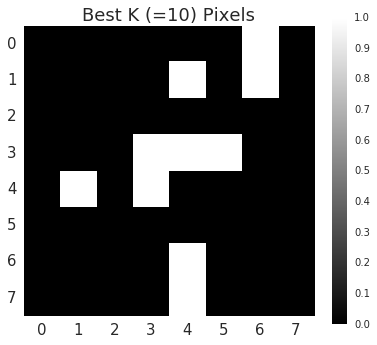

In [9]:
# Modified code from scikit example:
# http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline

# Number of pixels to keep
k = 10

# ANOVA SVM-C
anova = SelectKBest(f_regression, k=5)
svc = svm.SVC(kernel='linear')

# Create a pipeline, with names for pipe elements
anova_svm = Pipeline([('anova', anova), ('svc', svc)])

# You can set the parameters using the names
anova_svm.set_params(anova__k=k, svc__C=.1).fit(x, y)

# Apply Anova SVM
prediction = anova_svm.predict(x)
print('Anova SVM Score = {0:4.1f}%'.format(100.0* anova_svm.score(x, y)))

# Grab the best k pixels as chosen by Anova SVM
pixels = np.array(anova_svm.named_steps['anova'].get_support(), dtype=np.int8)
pixels = np.reshape(pixels, images[0].shape)

# Plot the result
fig, axs = plt.subplots(figsize=(6.5, 5.5))
sns.set(style='dark', font_scale=1.0)
plt.gray()
plt.imshow(pixels, interpolation='nearest')
plt.colorbar()
sns.set(style='dark', font_scale=1.5)
plt.title("Best K (={0:d}) Pixels".format(k))
plt.show()

-----

### Student Activity:


Now that you have run the previous cells, try making changes to the
Notebook:

1. Change the number of features to retain with `SelectKBest`. How does
increasing or decreasing the number of features change the pixel
importance image?

2. Try changing the classification method in the pipeline, for example
to an RFC. How does this change the pipeline's output?

3. Try changing the parameters of the new classification object, such as
`n_features` for an RFC. How does this change the pipeline's output?

Finally, think about the information contained in the pixel importance
images, does this provide any insight into the data, and how the
classifications performed (think, perhaps about our fake digits). How
does it compare to the RFE and RFC pixel images?

----

## Cross Validation

We have previously discussed [cross-validation][W1L1] as a method to
split data into training and testing data sets (we frequently use the
`train-test_split` method to do exactly this process). It is, of course,
vitally important that a model not see any test data when constructing
the model, or the model results may be biased. There are multiple
different cross validation methods, however, that can aid in selecting
the optimal model or model parameters for a given data set beyond a
simple train/test splitting.

The scikit learn library provides several [cross-validation
iterators][skcvi], including

- `KFold`, which splits the data into k _folds_, trains on the k folds
and tests on the left out data.
- `StratifiedKFold`, similar to `KFold` but preserves the labelled class
ratios within each fold.
- `LeaveOneOut`, which iteratively leaves one observation out to test on
the model trained on the remaining data.
- `ShuffleSplit`, which generate a user defined number of train/test
data sets, by first randomly shuffling the data.

Cross-validation is not only important in selecting among different
models, but is also important for selecting optimal model parameters, as
demonstrated in the following code cell. The plot that is generated
indicates the performance of an SVC, via the cross-validation score
metric, applied to the Handwritten Digit data as the `C` parameter is
varied.

-----

[W1L1]: ../../Week1/notebooks/intro2ml.ipynb
[skcvi]: http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators



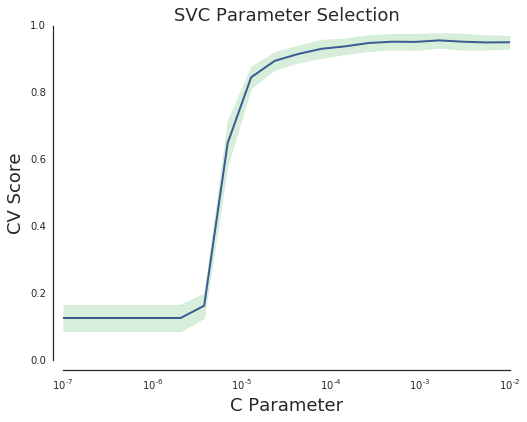

In [10]:
# Modified scikit Learn example:
# http://scikit-learn.org/stable/auto_examples/exercises/plot_cv_digits.html

# Create our k-Fold instance
from sklearn.cross_validation import KFold
kf = KFold(len(x), n_folds=5)

# Create classifier/sample parameter values
svc = svm.SVC(kernel='linear')
c_vals = np.logspace(-7, -2, 20)

# Loop over parameter values to accumulate statistics
scr_mu = list()
scr_sig = list()
for c in c_vals:
    svc.C = c
    score = cv.cross_val_score(svc, x, y, cv=kf)
    scr_mu.append(np.mean(score))
    scr_sig.append(np.std(score))

high = np.array(scr_mu) + np.array(scr_sig)
low = np.array(scr_mu) - np.array(scr_sig)

# Plot the results
sns.set(style="white", font_scale=1.0)
fig, ax = plt.subplots(figsize=(8,6))

plt.semilogx(c_vals, scr_mu, color=sns.xkcd_rgb["denim blue"], linewidth=2)
plt.fill_between(c_vals, high, low, color=sns.xkcd_rgb["medium green"], alpha=0.2)
plt.yticks()

plt.ylabel('CV Score', fontsize=18)
plt.xlabel('C Parameter', fontsize=18)
plt.title('SVC Parameter Selection', fontsize=18)

sns.despine(offset=10, trim=True)
plt.show()

-----

### Student Activity:


Now that you have run the previous cells, try making changes to the
Notebook:

1. Change the number of folds in the `KFold` algorithm. How does
CV score change?
2. Try changing the CV iterator technique, such as to `ShuffleSplit` or
`StratifiedKFold`. How does this change the CV score?

----

## Grid Search

Many machine learning algorithms have parameters that can be adjusted to
tune the performance of the algorithm on a particular data set, for
example, the `C` parameter in SVM. While in some cases there is a
theoretical justification for a particular parameter value when applied
to a specific data set, in many cases, we must determine the parameter
(sometimes called hyper-parameter) values programmatically. With
multiple parameters, however, this process can quickly become tedious,
e.g., when running DBSCAN and changing the `eps` and `min_samples`
parameters.

Rather than repeatedly manually changing parameter values and computing
the resulting model scores, a better approach is to employ a grid search
approach. In a grid search, one defines a grid of parameter values,
applies the model over all possible parameter value combinations in the
grid, and identifies the set of parameters that produces the best model
performance score. The scikit learn library provides a
[`GridSearchCV`][skgs] object that performs a grid search by using cross
validation, which produces a model score at the end.

In the following code cell, we demonstrate using `GridSearchCV` to
compute the best value for the `C` parameter when running the SVC
algorithm on the Handwritten Digit data. In this simple case, we simply
employ the estimator directly, however, a grid search is often most
effective when analyzing a pipeline that can have many free parameters.

-----
[skgs]: http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html

In [11]:
from sklearn.grid_search import GridSearchCV

(x_trn, x_tst, y_trn, y_tst) = cv.train_test_split(x, y, test_size=.2)

c_vals = np.logspace(-7, -2, 25)

clf = GridSearchCV(estimator=svc, param_grid=dict(C=c_vals))

clf.fit(x_trn, y_trn)

print('Best C={0:5.4f}'.format(clf.best_estimator_.C))
print('Best CV Score = {0:4.3f}'.format(clf.best_score_))
print('Test Score = {0:4.3f}'.format(clf.score(x_tst, y_tst)))

Best C=0.0015
Best CV Score = 0.977
Test Score = 0.986


-----

### Student Activity:


Now that you have run the previous cell, try making changes to the
Notebook:

1. Does the result of the grid search match the result in the cross
validation plot (they both analyze the `C` parameter in the same SVC
classification problem.

2. Try changing the classification method in the grid search, for
example to an RFC. How does this change the output?

-----

## Validation/Learning Curves

Earlier in this Notebook, we computed a cross-validation score for
different values of the SVM's `C` parameter. We then plotted the
cross-validation score against the different parameter values to see how
the score depended on the parameter. That plot is more commonly known
as a validation curve, which demonstrates the performance of an
algorithm as a parameter is varied. The scikit learn library provides the
[`validation_curve`][skvc] object, which is a direct mechanism for
computing the data necessary for this plot. In the first cell, we apply
an SVC by using cross validation, to the Handwritten Digit data to
determine the performance of this algorithm as the $\gamma$ parameter is
varied.

Of course there are three types of data used to score machine learning
algorithms:

1. Training Data
2. Validation Data
3. Testing Data

Training data provides an upper bound on the expected performance of an
algorithm, but since it is used to train the model, it is biased and
should never be quoted as the **actual** performance of an algorithm.
Validation data can also used to predict the performance of an
algorithm, but since an algorithm can still see validation data (during
the cross-validation process), these data can also produce biased
results. Testing data, on the other hand, should always be unseen by the
algorithm during training, and are thus the best data to use to quantify
the predictive power of an algorithm. 

The scikit learn `validation_curve` implementation displays both the
training data score and the validation data score. The performance of an
algorithm will, of course, vary as the quantity of training dat are
varied. Thus, a useful visual is the performance of an algorithm on
training and validation data for a fixed set of parameters, as a
function of the size of the training data. This second curve is known as
a _learning curve_ and is implemented in scikit learn by the
`learning_curve` object. Generally, a learning curve shows a convergence
in the performance of an algorithm on these two data sets, which is a
useful guide to understanding the optimal size of a training data set.
In the last two code cells, we compute and display the learning curve
for two different classifiers applied to the Handwritten Digit data: SVM
and Naive Bayes. In both cases, the score on the validation data
converges with (i.e., approaches) the training data score, which
provides insight into the optimal size of the validation data.

Note, the computation of the data for these curves can take a while,
since many different computations are performed (for each
training/validation sample size and for each step in the cross
validation process). 

-----

[skvc]: http://scikit-learn.org/stable/modules/learning_curve.html#validation-curve
[sklc]: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

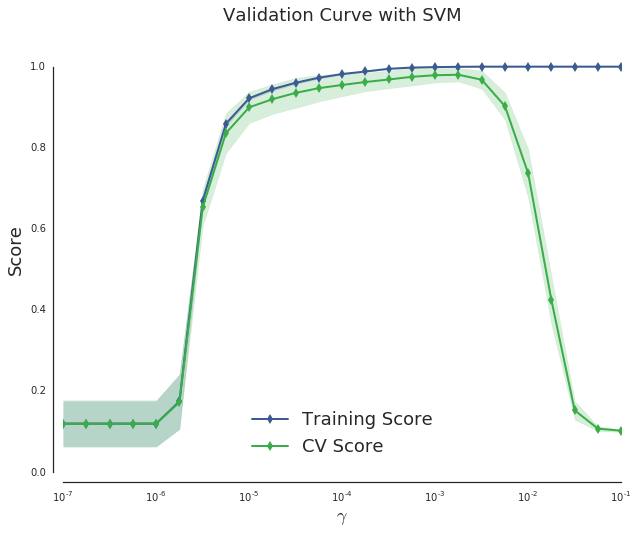

In [12]:
# Modified from scikit learn example:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html

from sklearn.learning_curve import validation_curve
from helper_code import vlcurves

param_range = np.logspace(-7, -1, 25)
trn_scr, tst_scr = validation_curve(svm.SVC(), x, y, param_name="gamma", \
                                    param_range=param_range, cv=10, scoring="accuracy")

y1, y1h, y1l, y2, y2h, y2l = vlcurves.get_range(param_range, trn_scr, tst_scr)

# Plot the results
sns.set(style="white", font_scale=1.0)
fig, ax = plt.subplots(figsize=(10,8))

# Plot data and ranges
trn_color = color=sns.xkcd_rgb["denim blue"]
plt.semilogx(param_range, y1, label="Training Score", marker='d', lw=2, color=trn_color)
plt.fill_between(param_range, y1h, y1l, alpha=0.2, color=trn_color)

tst_color = color=sns.xkcd_rgb["medium green"]
plt.semilogx(param_range, y2, label="CV Score", marker='d', lw=2, color=tst_color)
plt.fill_between(param_range, y2h, y2l, alpha=0.2, color=tst_color)

plt.title("Validation Curve with SVM", fontsize=18)
plt.xlabel('$\gamma$', fontsize=18)
plt.ylabel("Score", fontsize=18)
plt.ylim(0.0, 1.1)
plt.legend(loc="best", fontsize=18)

sns.despine(offset=10, trim=True)
plt.show()

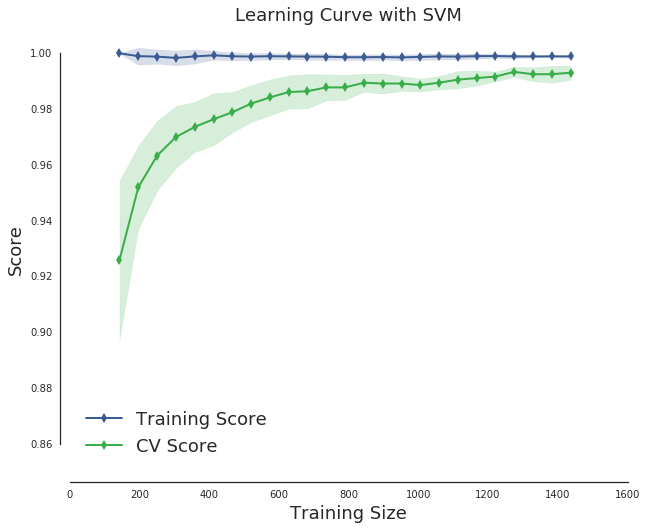

In [13]:
# Modified from scikit learn example:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import ShuffleSplit

trn_sz=np.linspace(0.1, 1, 25)

cv = ShuffleSplit(x.shape[0], n_iter=10, test_size=0.2, random_state=0)

svc = svm.SVC(gamma=0.001)
trn_szs, trn_scr, vld_scr = learning_curve(svc, x, y, cv=cv, train_sizes=trn_sz)

y1, y1h, y1l, y2, y2h, y2l = vlcurves.get_range(trn_szs, trn_scr, vld_scr)

title = 'Learning Curve with SVM'
vlcurves.lv_plot(title, trn_szs, y1, y1h, y1l, y2, y2h, y2l, 'Training Size', 'Score', ylim=(0.85, 1.01))

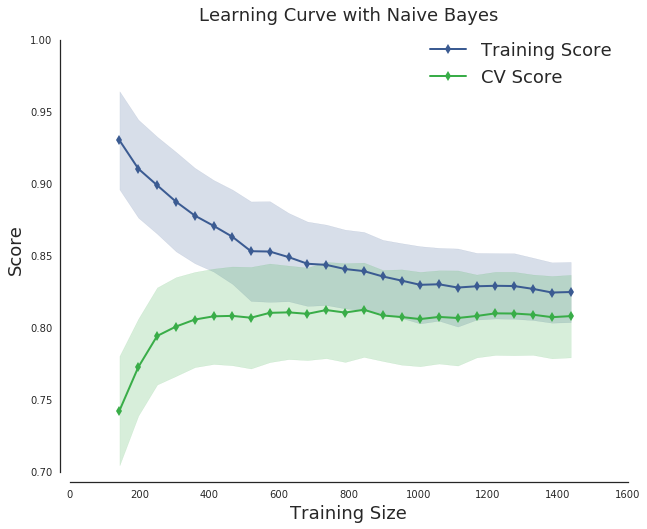

In [14]:
from sklearn.naive_bayes import GaussianNB

cv = ShuffleSplit(x.shape[0], n_iter=100, test_size=0.2)

trn_sz=np.linspace(0.1, 1, 25)

nb = GaussianNB()

trn_szs, trn_scr, vld_scr = learning_curve(nb, x, y, cv=cv, train_sizes=trn_sz)

y1, y1h, y1l, y2, y2h, y2l = vlcurves.get_range(trn_szs, trn_scr, vld_scr)

title = 'Learning Curve with Naive Bayes'
vlcurves.lv_plot(title, trn_szs, y1, y1h, y1l, y2, y2h, y2l, 'Training Size', 'Score', ylim=(0.7, 1.01))

-----

### Student Activity

In the preceding cells, we used validation and learning curves to
explore the performance of a classification algorithm on the Handwritten
Digit data. Now that you have run the Notebook, go back and make the
following changes to see how the results change.

1. Compute a validation curve for the `C` parameter. Does this curve
resemble the previous plot we constructed by hand for this parameter?
2. Change the cross-validation technique in the last example from
`ShuffleSplit` to `KFold` and then `StratifiedKFold`. How does this
change the resulting figure?
3. Try changing the parameters in the SVC and NB classifiers. How does
this change the resulting figure?
4. Try using a different classifier, for example, decision tree, or
k-nn. How does this change the resulting figure?


-----